### 研究動機：特斯拉主題分類以及預測銷售量任務
工具：
+ week4 情緒分析(CKIP)
+ week5 情緒分析(SnowNLP), NFR、
+ Week6 Bigram, TD-IDF、
+ Week7 模型與分類器訓練
+ Week10 LDA
+ Week11 字與字的關聯, Transform model(like bert but Decoder-only), Embedding分類任務
+ Week12 bert(encoder-only-model)
+ Week13 LLM 
+ Week14 社會網路圖
+ Week15 進階社群網路圖

資料來源：
+ 資料來源：PPT車版
+ 關鍵字：特斯拉、Tesla
+ 資料筆數：1215篇
+ 訓練資料日期：2023/1/1 - 2023/12/31
+ 新資料日期：202/1/1 - 2024/3/31

可能的分析方向：
+ 社群媒體分析：探索特斯拉在不同社群媒體平台上的評論和討論。如特斯拉的技術創新、環保意識等。
+ 市場趨勢預測：分析特斯拉的新產品發布、重大事件或競爭對手的動態對市場的影響，並進行股市趨勢預測。
+ 產品品質分析：使分析消費者的投訴、讚美和建議，並進行情緒分類和主題分析，探討產品品質的缺點與優點。
+ 競爭分析：分析特斯拉與其他競爭對手的比較。特斯拉和其他汽車品牌的情緒和評價，了解特斯拉市場上的定位和競爭策略。

以產品品質分析+市場趨勢(銷量)分析為例：
+ 分析過程：1. 透過Guide-LDA做主題分類，將特斯拉主題試著分類(客訴：服務(人員接待)、物流(到貨速度、零件物流)、配套(充電樁、維修站)、價格、安全(過熱、火燒車、爆炸、暴衝、失控)、使用者體驗(公差、電池、低溫))並產生主題標籤。
+ 分析過程：2. 將文章做情緒分析(SnowNLP)，分析負面與正面原因
+ 分析過程：3. n-gram捕捉特斯拉產品相關的常用詞彙、計算字與字的關聯度分數
+ 分析過程：4. 加入新文章，分別使用embedding/DTM 搭配 分類器模型來分類新文章，順便看哪個效果較好
+ 分析過程：5. 以季度為單為，透過情緒分析來預測汽車銷量(需要用到回歸模型 但課程沒教)

問題：
+ 透過非監督式學習LDA的分類後產生標籤，再將標籤後的文章透過embedding+分類訓練器，將後續匯入的新文章賦予標籤這件事情是否合理？ 會不會新文章直接丟進去LDA效果更好？LDA是否也有fine-tune 就不需要重跑一次
+ 好東西都在"artComment"但課程好像沒有去解析artComment欄位，都是針對artContent去分析，這個部分可以保留未來執行

In [57]:
import time 
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import re #re: 正規表達式套件。
import math #math: 數學運算工具。
import datetime
import os
from pprint import pprint

import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。

import jieba #jieba: 中文斷詞套件。
import jieba.analyse

import pyLDAvis
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import guidedlda

from wordcloud import WordCloud 
from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
from collections import Counter, namedtuple #collections: 提供額外的數據類型。
import networkx as nx #networkx: 網絡圖建構、繪製工具。
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)

from getpass import getpass
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from transformers import BitsAndBytesConfig # huggingface 量化

from langchain_community.llms import HuggingFaceEndpoint

from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables import RunnableLambda

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

In [2]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] #金萱粉圓體2.0
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] 

# 設定文字雲中文字體路徑 金萱粉圓體2.0
FontPath = 'path/to/jf-openhuninn-2.0.ttf' # 設定字型
# FontPath = './SourceHanSansTW-Regular.otf' # 設定字型

plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

# Path to the custom font
font_path = 'font/jf-openhuninn-2.0.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break


Found font: jf-openhuninn-2.0


In [3]:
#匯入資料
df = pd.read_csv('./data/PTT_Tesla_2023.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df.head(3)

,artDate,artTitle,artContent
0,2023-01-01 10:48:19,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....
1,2023-01-01 22:42:25,[問題]特斯拉久了會掉電嗎？,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...
2,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結：\nhttps://star.setn.com/news/1232578?utm_...


In [4]:
MetaData = df.copy()
MetaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
#MetaData['artDate'] =  pd.to_datetime(MetaData['artDate']).dt.to_period('D')

# 只留下中文字
MetaData['artContent'] = MetaData['artContent'].str.replace("(http|https)://.*", "", regex=True)
MetaData['artTitle'] = MetaData['artTitle'].str.replace("(http|https)://.*", "", regex=True)
MetaData['artContent'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['artTitle'] = MetaData['artTitle'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))


MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['sentence'] = MetaData['sentence'].apply(lambda x: re.sub('[口]', '', x))

MetaData.head(3)

,artDate,artTitle,artContent,sentence
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...


In [5]:
raw_data = MetaData.copy()
raw_data['content'] = raw_data['artContent']
raw_data = raw_data.loc[:,["artDate", "content", ]]  # 文章內容 文章連結
raw_data.head(3)

,artDate,content
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...


In [6]:
missing_values = raw_data[raw_data["content"].isnull()]
print("具有缺失值的行：")
print(missing_values)

具有缺失值的行：
Empty DataFrame
Columns: [artDate, content]
Index: []


In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")
#jieba.load_userdict('./dict/BBWord.txt')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [8]:
raw_data["words"] = raw_data["content"].apply(getToken)
raw_data.head()

Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/林憲聰/dict/dict.txt ...
Dumping model to file cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.u305201809755409ef22c4a6fed224138.cache
Loading model cost 0.290 seconds.
Prefix dict has been built successfully.


,artDate,content,words
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"[八卦, 官網, 特斯拉, 二手車, 三方, 平台, 便宜, 黨會, 勝利]"
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"[前輩, 中古, 特斯拉, 里程, 擔心, 電池, 電越, 充越, 少電, 里程數, 越少開..."
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"[王家, 徐兆緯, 台北, 電競, 世界, 冠軍, 日前, 直播, 自動, 駕駛, 雙手, ..."
3,2023-01-02 18:01:04,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"[如題, 特斯拉, 最近, 出門, 車位, 很煩, 騎家裡, 超舊, 機車, 機車道, 機車..."
4,2023-01-02 19:21:24,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"[美國, 汽車, 召回, 排名, 揭曉, 超過, 萬輛車, 進廠, 處理, 結束, 迎來, ..."


In [10]:
# 將['words']轉成list
docs = raw_data['words'].to_list()

dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

Dictionary<4149 unique tokens: ['三方', '二手車', '便宜', '八卦', '勝利']...>


In [11]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

三方: 0
二手車: 1
便宜: 2
八卦: 3
勝利: 4
官網: 5
平台: 6
特斯拉: 7
一點: 8
中古: 9
之後: 10
公里: 11


In [12]:
print(" ".join(raw_data['words'].iloc[600]))

有片 選車 民調 購買 燃油車 大宗 電動車 比例 增加 藍于 更新 台灣 電動車 成長 家庭 擁有 汽機車 但純 電動車 比例 台灣 調查 發現 民眾 願意 換購 電動車 比例 提高 半數 人會 推薦 周邊 朋友 購入 電動車 油車 持有人 每個 油車 裡面 一顆 電池 汽車 電池 充電 幾個 好處 延長 電池 壽命 定期 充電 避免 汽車 電池 長期 閒置 失去 電力 延長 電池 壽命 充電 補充 電池 電能 保持 電池 正常 運作 狀態 避免 起動 困難 充足 電力 確保 汽車 起動 足夠 能量 提供給 啟動 馬達 電子 系統 充電 確保 電池 始終 處於 充足 狀態 減少 起動 困難 風險 維持 電子 設備 運作 現代 汽車 配備 電子 設備 音響 系統 導航 系統 車載 電腦 設備 穩定 電源 供應 正常 運作 充電 確保 電池 足夠 電力 支持 電子 設備 運作 優點 這麼多 優先 更多 享受到 充電 優點 電動車 車位 開放給 電池 充電 好不好 一下 打開 充電 孔有 寧德 時代 亞迪 湯愛 馬龍 沒什麼 贊同 我算過 我大蓋 充個 小時 特斯拉 沒什麼 兩樣


In [13]:
dictionary.doc2bow(raw_data['words'].iloc[600])[:10]

[(7, 1),
 (27, 6),
 (28, 10),
 (29, 1),
 (51, 1),
 (72, 1),
 (114, 1),
 (141, 4),
 (174, 1),
 (179, 1)]

In [14]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]
type(corpus)

In [16]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=3, # 生成幾個主題數
    random_state=2024, # 亂數
)

In [17]:
ldamodel.print_topics()

[(0,
  '0.028*"特斯拉" + 0.015*"汽車" + 0.014*"充電" + 0.014*"電動車" + 0.009*"中國" + 0.008*"車主" + 0.008*"駕駛" + 0.005*"公司" + 0.005*"使用" + 0.005*"自動"'),
 (1,
  '0.012*"特斯拉" + 0.011*"電動車" + 0.010*"汽車" + 0.010*"駕駛" + 0.009*"充電" + 0.007*"電池" + 0.006*"品牌" + 0.005*"車主" + 0.005*"中國" + 0.004*"電車"'),
 (2,
  '0.027*"特斯拉" + 0.015*"電動車" + 0.008*"電池" + 0.007*"台灣" + 0.007*"汽車" + 0.006*"充電" + 0.005*"車主" + 0.005*"中國" + 0.005*"問題" + 0.005*"公司"')]

In [18]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

-7.633980699454112

In [19]:
np.exp2(-perplexity)

198.63564130534755

In [20]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

這個主題的 PMI score:  -0.01837525412017291


In [21]:
NPMI_model_lda.get_coherence_per_topic()

[-0.015098603795526699, -0.012831714902049898, -0.02719544366294214]

In [22]:
t0 = time.time()

topic_num_list = np.arange(2, 14)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=70 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 52.2 sec

花費時間: 52.26449680328369 sec


<Axes: xlabel='topic_num'>

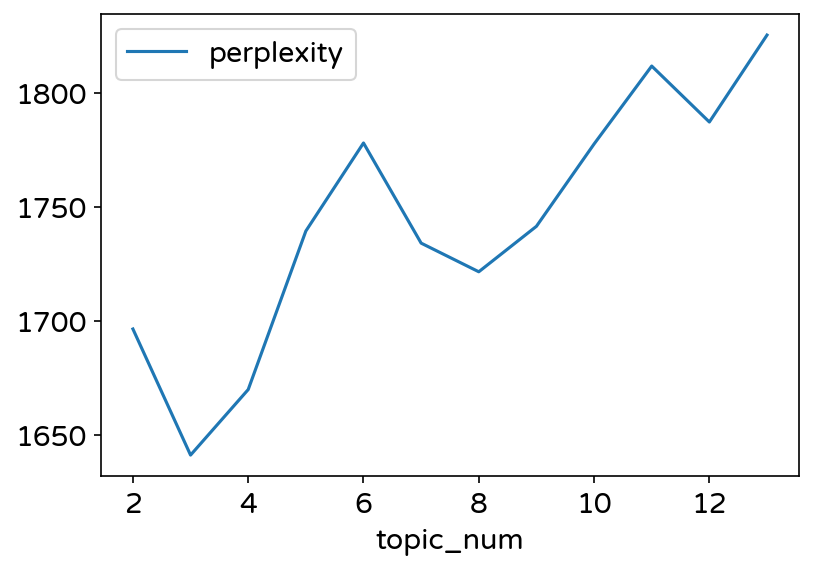

In [23]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

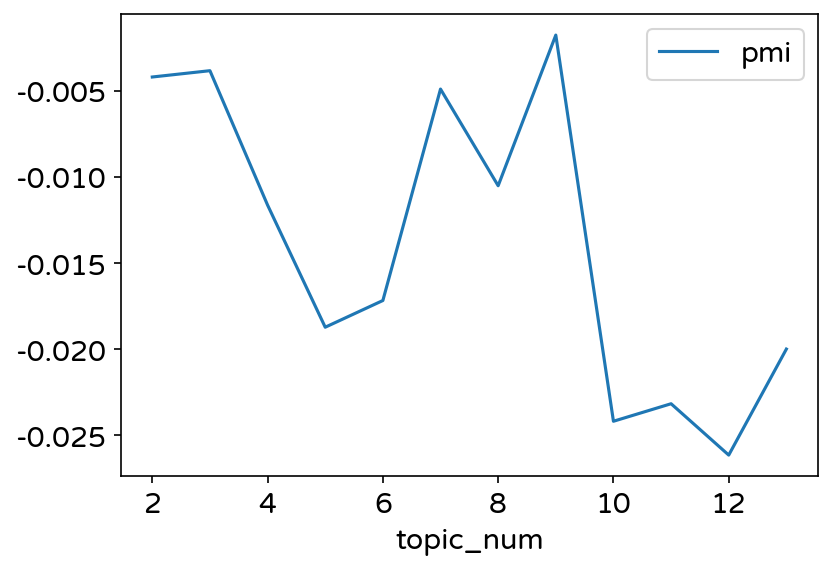

In [24]:
result.plot.line(x='topic_num', y='pmi')

In [25]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 1500,
    passes = 70 # 訓練次數
    )

In [26]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.204588  0.011437       1        1  40.224184
0      0.089828 -0.146493       2        1  37.187839
2      0.114760  0.135056       3        1  22.587977, topic_info=    Term         Freq        Total Category  logprob  loglift
102   駕駛   852.000000   852.000000  Default  30.0000  30.0000
7    特斯拉  2895.000000  2895.000000  Default  29.0000  29.0000
355   中國   799.000000   799.000000  Default  28.0000  28.0000
27   電動車  1689.000000  1689.000000  Default  27.0000  27.0000
141   汽車  1273.000000  1273.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
24    車子    95.676000   317.955733   Topic3  -5.6890   0.2868
862   知道    96.181872   359.787723   Topic3  -5.6838   0.1685
504   直接    88.680760   295.777413   Topic3  -5.7650   0.2832
419   使用    88.394968   502.894497   Topic3  -5.7682  -0.2508
27   電動車    89.482465  1689.252285   Topic3  -5.7560  -1.4502

[236 rows x 6 columns], token_table=      Topic      Freq Term
term                      
29        1  0.034048   一下
29        2  0.879060   一下
29        3  0.089763   一下
292       1  0.213195   一輛
292       2  0.022842   一輛
...     ...       ...  ...
102       2  0.095015   駕駛
102       3  0.863346   駕駛
2034      3  0.977628  駕駛人
3548      1  0.988383   鴻海
1017      2  0.988264   麻煩

[374 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [91]:
# 從LDA模型獲取主題詞彙：
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

INFO:gensim.models.ldamodel:topic #0 (0.333): 0.028*"特斯拉" + 0.015*"汽車" + 0.014*"充電" + 0.014*"電動車" + 0.009*"中國" + 0.008*"車主" + 0.008*"駕駛" + 0.005*"公司" + 0.005*"使用" + 0.005*"自動"
INFO:gensim.models.ldamodel:topic #1 (0.333): 0.012*"特斯拉" + 0.011*"電動車" + 0.010*"汽車" + 0.010*"駕駛" + 0.009*"充電" + 0.007*"電池" + 0.006*"品牌" + 0.005*"車主" + 0.005*"中國" + 0.004*"電車"
INFO:gensim.models.ldamodel:topic #2 (0.333): 0.027*"特斯拉" + 0.015*"電動車" + 0.008*"電池" + 0.007*"台灣" + 0.007*"汽車" + 0.006*"充電" + 0.005*"車主" + 0.005*"中國" + 0.005*"問題" + 0.005*"公司"


Topic: 0 
Words: 0.028*"特斯拉" + 0.015*"汽車" + 0.014*"充電" + 0.014*"電動車" + 0.009*"中國" + 0.008*"車主" + 0.008*"駕駛" + 0.005*"公司" + 0.005*"使用" + 0.005*"自動"
Topic: 1 
Words: 0.012*"特斯拉" + 0.011*"電動車" + 0.010*"汽車" + 0.010*"駕駛" + 0.009*"充電" + 0.007*"電池" + 0.006*"品牌" + 0.005*"車主" + 0.005*"中國" + 0.004*"電車"
Topic: 2 
Words: 0.027*"特斯拉" + 0.015*"電動車" + 0.008*"電池" + 0.007*"台灣" + 0.007*"汽車" + 0.006*"充電" + 0.005*"車主" + 0.005*"中國" + 0.005*"問題" + 0.005*"公司"


In [28]:
# 建立詞彙表和詞彙ID對應表
vocab = tuple(dictionary.token2id.keys())
word2id = dictionary.token2id

In [136]:
seed_topic_list = [
    ['隱私', '改善', '討厭'],   # 投訴方面
    ['等待', '零件', '維修'],    #物流方面
    ['充電'],    #配套方面
    ['價格', '優惠', '促銷', '二手價'], # 產品性價比面
    ['衝撞', '道路', '車禍', '起火'],   #安全性能面
    ['煞車'],    #使用者體驗
]


In [137]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [138]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [139]:
# n_topics：指定要生成的主題數量。在這裡設定為4，表示模型將生成4個主題。
# n_iter：指定模型迭代的次數。更多的迭代通常會產生更穩定的結果。在這裡設定為100次。
# random_state：設定隨機種子，以便結果可重現。在這裡設定為2024。
# refresh：指定模型每多少次迭代打印一次當前狀態。在這裡設定為20次，表示每20次迭代會打印一次模型狀態。
glda_model = guidedlda.GuidedLDA(n_topics=7, n_iter=1000, random_state=2024, refresh=500)
glda_model.fit(X, seed_topics=seed_topics, seed_confidence=1)

INFO:guidedlda:n_documents: 1215
INFO:guidedlda:vocab_size: 4149
INFO:guidedlda:n_words: 125211
INFO:guidedlda:n_topics: 7
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -1303126
INFO:guidedlda:<500> log likelihood: -945395
INFO:guidedlda:<999> log likelihood: -943605


In [140]:
# 整理／顯示主題模型結果
n_top_words = 7
topic_word = glda_model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = glda_model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 特斯拉 現在 一下 電車 問題 知道 看到
Topic 1: 電動車 汽車 中國 特斯拉 電池 公司 美國
Topic 2: 充電 電動車 特斯拉 超充 車主 使用 充電站
Topic 3: 特斯拉 台灣 品牌 降價 電動車 銷量 銷售
Topic 4: 特斯拉 車主 駕駛 發生 車輛 公司 說明
Topic 5: 報名 車馬費 台北市 活動 網頁 汽車 使用
Topic 6: 駕駛 特斯拉 自動 系統 功能 輔助 車輛


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.012732  0.114564       1        1  30.709958
1     -0.014778  0.211143       2        1  22.138054
3     -0.027943  0.216921       3        1  15.060610
6      0.193627 -0.089809       4        1  12.130919
4      0.178649 -0.131953       5        1  10.414930
2      0.012293 -0.177410       6        1   6.214563
5     -0.354580 -0.143455       7        1   3.330966, topic_info=    Term         Freq        Total Category  logprob  loglift
423   充電  1206.000000  1206.000000  Default  30.0000  30.0000
141   汽車  1306.000000  1306.000000  Default  29.0000  29.0000
102   駕駛   887.000000   887.000000  Default  28.0000  28.0000
27   電動車  1733.000000  1733.000000  Default  27.0000  27.0000
7    特斯拉  2993.000000  2993.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
118   主要    35.746412   189.512336   Topic7  -4.7594   1.7339
180   車主    35.746412   815.470804   Topic7  -4.7594   0.2746
922   相關    29.790331   125.601772   Topic7  -4.9417   1.9630
396   車型    29.790331   250.353589   Topic7  -4.9417   1.2732
533   公司    29.790331   571.844038   Topic7  -4.9417   0.4472

[460 rows x 6 columns], token_table=      Topic      Freq Term
term                      
29        1  0.977300   一下
29        2  0.021115   一下
967       1  0.947087   一台
967       3  0.054119   一台
291       2  0.091023   一名
...     ...       ...  ...
2297      6  0.581951   高雄
2297      7  0.276427   高雄
2630      7  1.004305  高雄市
3548      2  1.000116   鴻海
1017      1  1.000218   麻煩

[741 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 7, 5, 3, 6])

In [144]:
# 取得每條文章的主題分佈
topics_doc = best_model.get_document_topics(corpus)
topics_doc[100]

[(0, 0.9844228)]

In [36]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.05105071, 0.90684557, 0.0421037 ],
       [0.97320247, 0.01413158, 0.01266594],
       [0.        , 0.        , 0.99337912],
       ...,
       [0.04037111, 0.03398181, 0.92564708],
       [0.        , 0.79126656, 0.20485917],
       [0.9974376 , 0.        , 0.        ]])

In [37]:
raw_data['topic_label'] = m_theta.argmax(axis=1) + 1

In [38]:
raw_data['topic_label'].value_counts()

topic_label
1    535
2    387
3    293
Name: count, dtype: int64

In [39]:
raw_data.head()

,artDate,content,words,topic_label
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"[八卦, 官網, 特斯拉, 二手車, 三方, 平台, 便宜, 黨會, 勝利]",2
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"[前輩, 中古, 特斯拉, 里程, 擔心, 電池, 電越, 充越, 少電, 里程數, 越少開...",1
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"[王家, 徐兆緯, 台北, 電競, 世界, 冠軍, 日前, 直播, 自動, 駕駛, 雙手, ...",3
3,2023-01-02 18:01:04,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"[如題, 特斯拉, 最近, 出門, 車位, 很煩, 騎家裡, 超舊, 機車, 機車道, 機車...",1
4,2023-01-02 19:21:24,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"[美國, 汽車, 召回, 排名, 揭曉, 超過, 萬輛車, 進廠, 處理, 結束, 迎來, ...",2


In [40]:
raw_data['artDate'] = pd.to_datetime(raw_data['artDate'])

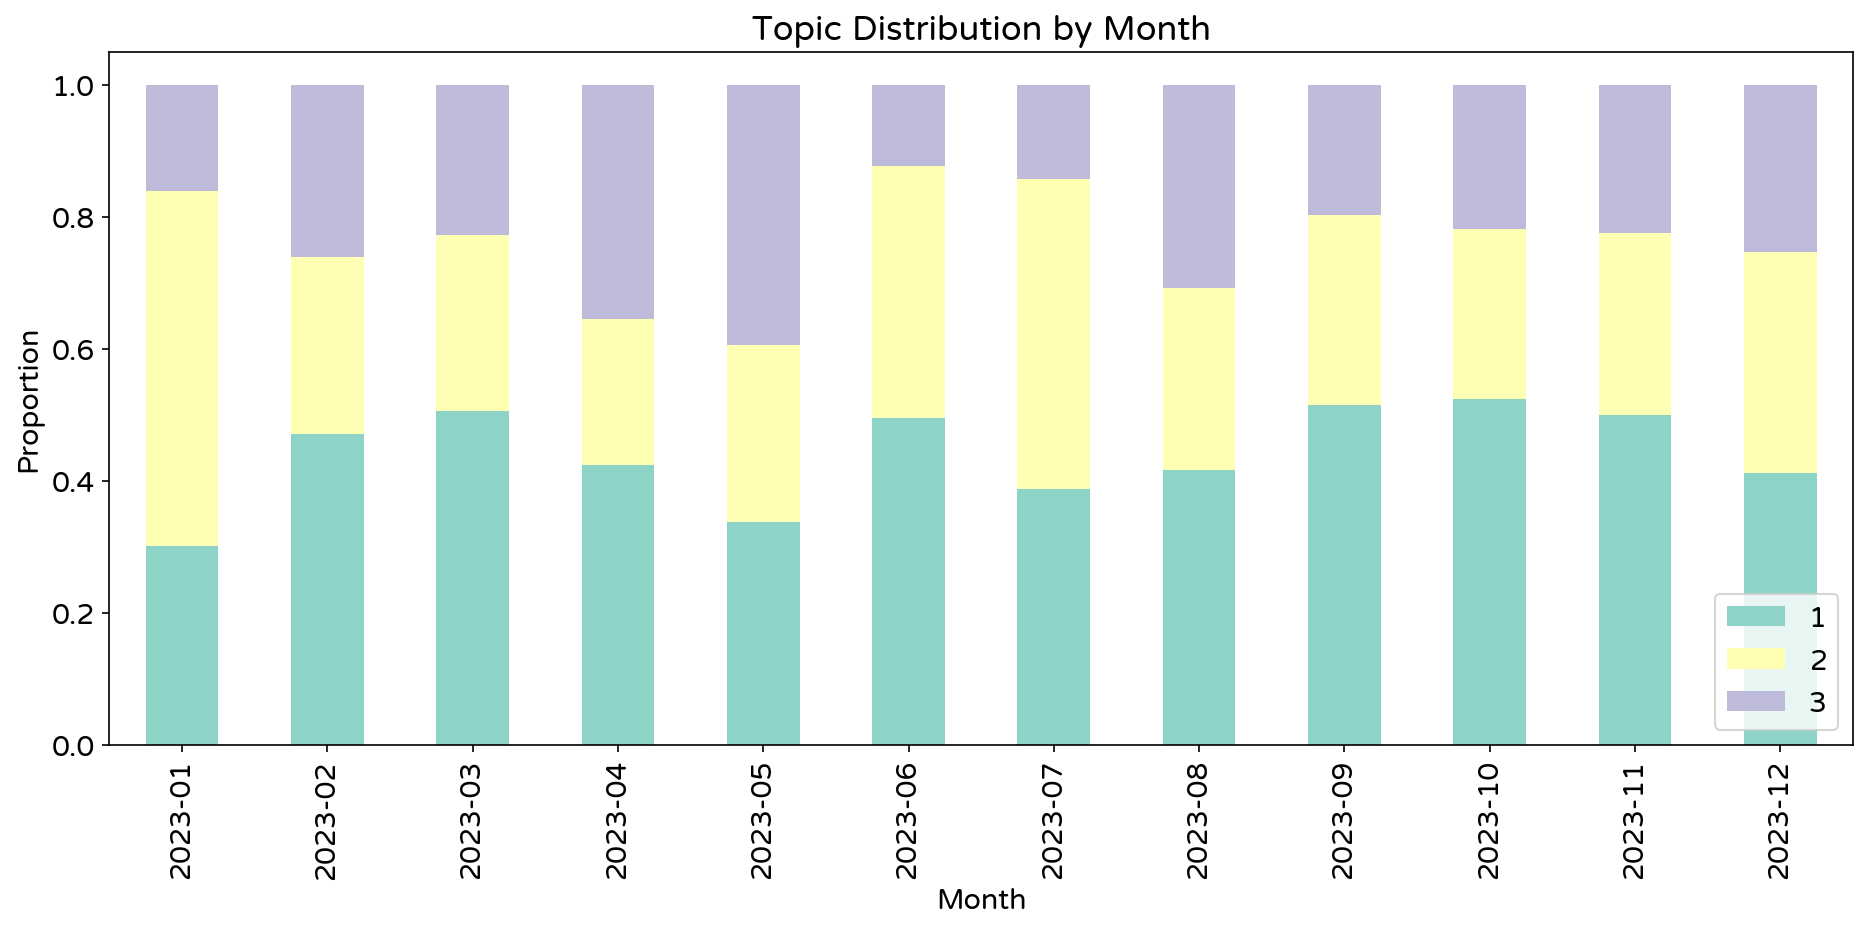

In [41]:
# 以月為單位
raw_data['month'] = raw_data['artDate'].dt.to_period('M')
month_topic = raw_data.groupby(raw_data['month'])['topic_label'].value_counts(normalize=True).unstack()
month_topic.head(3)

fig, ax = plt.subplots(figsize=(15, 6))
month_topic.plot.bar(ax=ax, stacked=True, color=plt.cm.Set3.colors)
ax.legend(loc='lower right')
ax.set_xlabel('Month')
ax.set_ylabel('Proportion')
ax.set_title('Topic Distribution by Month')
plt.show()

In [42]:
# 以日為單位
# raw_data.groupby(raw_data['artDate'].dt.date)['topic_label'].value_counts(normalize=True)
# date_topic = raw_data.groupby(raw_data['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
# date_topic.head()

# fig, ax = plt.subplots(figsize=(15, 6))
# date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
# ax.legend(loc='lower right')

In [43]:
raw_data

,artDate,content,words,topic_label,month
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"[八卦, 官網, 特斯拉, 二手車, 三方, 平台, 便宜, 黨會, 勝利]",2,2023-01
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"[前輩, 中古, 特斯拉, 里程, 擔心, 電池, 電越, 充越, 少電, 里程數, 越少開...",1,2023-01
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"[王家, 徐兆緯, 台北, 電競, 世界, 冠軍, 日前, 直播, 自動, 駕駛, 雙手, ...",3,2023-01
3,2023-01-02 18:01:04,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"[如題, 特斯拉, 最近, 出門, 車位, 很煩, 騎家裡, 超舊, 機車, 機車道, 機車...",1,2023-01
4,2023-01-02 19:21:24,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"[美國, 汽車, 召回, 排名, 揭曉, 超過, 萬輛車, 進廠, 處理, 結束, 迎來, ...",2,2023-01
...,...,...,...,...,...
1210,2023-12-30 13:22:05,特斯拉超充要花費的成本是最低的因為土地地主要無償提供給特斯拉電車網紅有訪問過超充地主你說連地...,"[特斯拉, 超充, 花費, 成本, 土地, 主要, 無償, 提供給, 特斯拉, 電車, 網紅...",1,2023-12
1211,2023-12-30 16:47:46,最近特斯拉新更新把輔助駕駛搭配車內鏡頭變得更嚴格總之會偵測你眼睛有沒有在看前方或者是不是在睡...,"[最近, 特斯拉, 更新, 輔助, 駕駛, 搭配, 鏡頭, 變得, 嚴格, 偵測, 眼睛, ...",3,2023-12
1212,2023-12-30 17:44:17,好有共鳴雖然我不是小眼睛但我是斜視看前面就像吉娃娃的眼睛也是一直被警告後來我把內鏡頭貼起來就...,"[共鳴, 眼睛, 斜視, 前面, 吉娃娃, 眼睛, 一直, 警告, 鏡頭, 沒事, 車內, 鏡頭]",3,2023-12
1213,2023-12-30 21:39:18,心得特斯拉也太不衛生了吧這是最低兩百萬最高到四五百萬的豪車耶怎可以有床蝨這種髒東西還整船被澳...,"[特斯拉, 衛生, 最低, 兩百萬, 高到, 四五百萬, 豪車, 床蝨, 這種, 髒東西, ...",2,2023-12


In [44]:
data = MetaData.copy()

# 對 'sentence' 欄位應用斷詞函數
data['words'] = data['sentence'].apply(getToken)

# 將 'words' 欄位展開成多行
data = data.explode('words')

# 將展開後的 'words' 欄位重命名為 'word'
data = data.rename(columns={'words': 'word'})

data.head(3)

,artDate,artTitle,artContent,sentence,word
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,官網
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,特斯拉


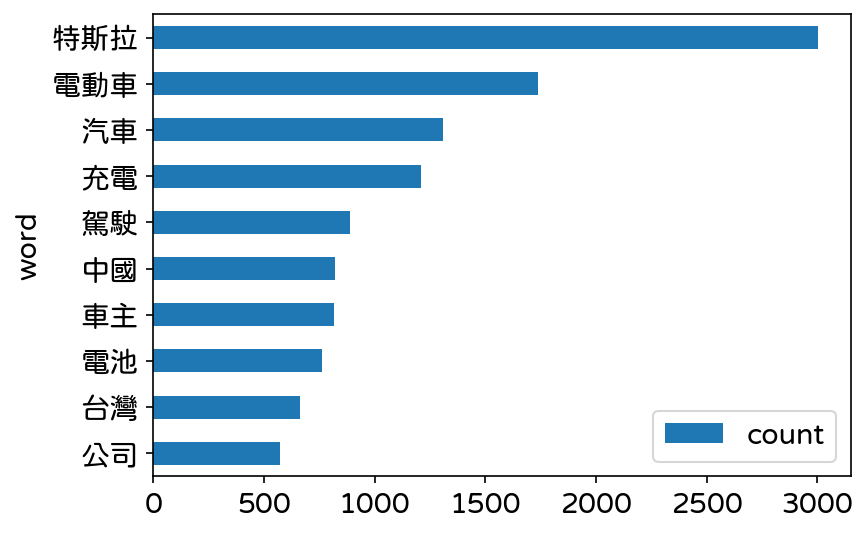

In [45]:
barplot_data = pd.DataFrame(pd.value_counts(data['word'])).reset_index()
barplot_data.columns = ['word','count']
barplot_data = barplot_data.sort_values(by = 'count', ascending = False).reset_index(drop = True)
# barplot_data.to_csv("select_stopword_data.csv", index=False)
barplot_data.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

In [47]:
#新增停用字
stopWords_manual = []
stopWords.extend(stopWords_manual)

# 重新去除停用字
data['word'] = data.sentence.apply(getToken).explode('word')

KeyboardInterrupt: 

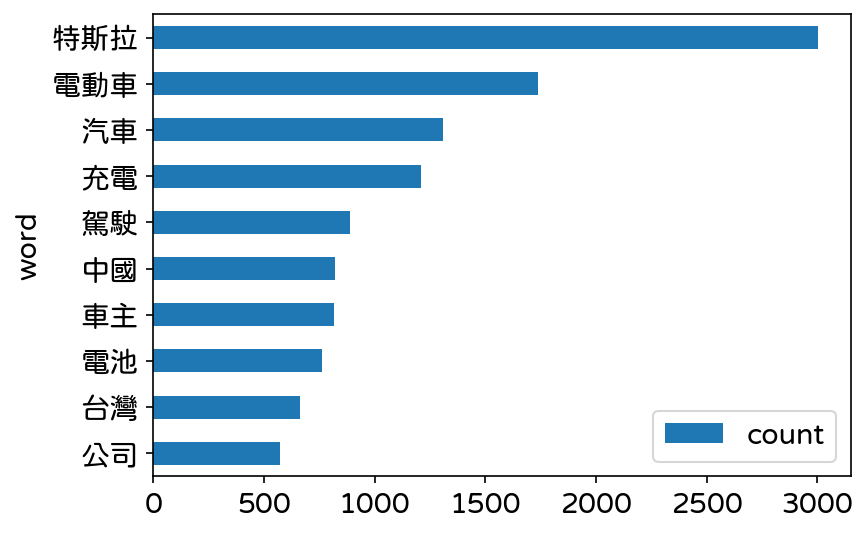

In [48]:
barplot_data = pd.DataFrame(pd.value_counts(data['word'])).reset_index()
barplot_data.columns = ['word','count']
barplot_data = barplot_data.sort_values(by = 'count', ascending = False).reset_index(drop = True)
#barplot_data.to_csv("barplot_data.csv", index=False)
barplot_data.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

In [58]:
HUGGINGFACEHUB_API_TOKEN = getpass()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

In [70]:
llm = HuggingFaceEndpoint(
    repo_id="google/gemma-1.1-7b-it", temperature=1.0,model_kwargs={'token':HUGGINGFACEHUB_API_TOKEN, 'use_cache':False}
)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/aiden/.cache/huggingface/token
Login successful


In [68]:
MetaData.head()

,artDate,artTitle,artContent,sentence
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...


In [72]:
# Few-shot Template
fewshot_template = """<start_of_turn>user
你是一個強大的語言模型，能夠根據給定的文本進行分類。你需要根據以下五種類型將文章進行分類與文章的情緒分類：

1. 服務方面(憲聰)：特斯拉售前、售後整體過程之服務。
2. 車輛交付方面：從下訂單到車輛交付的方面。
3. 性價比方面：衡量特斯拉價格與其所能提供的能力
4. 安全性方面：特斯拉的主動和被動安全措施、電池安全、充電安全以及整車安全設計等多個方面。
5. 使用者體驗：從車輛的駕駛感受、操作界面、智慧化功能到軟硬體支援等多個面向的體驗。


範例1
句子：這款電動車雖然價格不便宜，但確實是物有所值
抓取結果：{{
    "文章分類":"性價比方面",
    "情緒":"正面",
}}

以下是一些例子：
文本：特斯拉的新款電動車真是糟糕透頂，客服人員的態度非常差，根本不解決問題。
分類：投訴方面

文本：我等了三個月才拿到特斯拉的維修零件，太誇張了。
分類：物流方面

文本：特斯拉在我們城市的充電樁實在是太少了，經常找不到地方充電。
分類：配套方面

文本：這款電動車雖然價格不便宜，但確實是物有所值。
分類：產品性價格面

文本：我的特斯拉突然失控，差點撞車，這也太危險了吧！
分類：安全性能面

文本：這款電動車在低溫時電池耗電速度太快了，影響使用體驗。
分類：使用者體驗

請使用繁體中文回答。
除了 JSON 內容外，不要回答任何其他內容

現在請回答以下問題：
文本：{text}<end_of_turn>
<start_of_turn>model
分類："""

fewshot_prompt = PromptTemplate.from_template(fewshot_template)

fewshot_chain = (
    {"text": RunnablePassthrough()}
    | fewshot_prompt
    | llm
)

# CoT Loop
for i in range(1, 6):
    print(f"\n\n========== Run {i} ==========\n\n")
    print(fewshot_chain.invoke(MetaData['artContent'].iloc[0]))




========== Run 1 ==========


產品性價格面

該段文字討論的是特斯拉二手車的價格，並表明特斯拉二手車比其他第三方平台更便宜。這與產品性價格面分類相符。


========== Run 2 ==========


產品性價格面

該文本討論的是特斯拉二手車的價格，並表示其比第三方平台更便宜。這與產品性價格面分類的定義一致。


========== Run 3 ==========


產品性價格面

文本提到特斯拉二手車的價格比第三方平台便宜，這表明特斯拉二手車的產品性價格面便宜。


========== Run 4 ==========


產品性價格面

這段文字討論的是特斯拉二手車的價格，並認為特斯拉二手車比其他第三方平台便宜。這與產品性價格面分類的定義相符，因為這是一個與產品價格相關的陳述。


========== Run 5 ==========


產品性價格面

這個句子表示特斯拉的二手車比其他平台便宜，因此這句文字與產品性價格面分類相符。


In [74]:
def classify_text(text):
    return fewshot_chain.invoke(text)

In [77]:
# 初始化新欄位
MetaData['llm_class'] = ""
MetaData.head(3)

,artDate,artTitle,artContent,sentence,llm_class
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,


In [ ]:
# 將MetaData拆分成13份
split_dfs = np.array_split(MetaData, 13)

# 定義一個函數來處理每個分割的資料
def process_split_df(split_df, index):
    split_df['llm_class'] = split_df['artContent'].apply(classify_text)
    split_df.to_csv(f'./data/PTT_Tesla_2023_classified_part_{index}.csv', index=False, encoding='UTF-8')

# 逐個處理每個分割的資料
for i, split_df in enumerate(split_dfs):
    process_split_df(split_df, i)

# # 逐個處理每個分割的資料，從part_11開始
# for i in range(11, 13):
#     print(f"Processing part {i}")
#     process_split_df(split_dfs[i], i)

In [217]:
# 讀取所有 CSV 檔案並合併為一個 DataFrame
llms_class = pd.concat([
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_0.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_1.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_2.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_3.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_4.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_5.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_6.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_7.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_8.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_9.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_10.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_11.csv', encoding='UTF-8'),
    pd.read_csv('./data/PTT_Tesla_2023_classified_part_12.csv', encoding='UTF-8')
], ignore_index=True)

# 重設 index 並將新的 index 命名為 'system_id'
llms_class = llms_class.reset_index().rename(columns={'index': 'system_id'})

# 顯示更新後的 DataFrame
llms_class

,system_id,artDate,artTitle,artContent,sentence,llm_class
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,產品性價格面\n\n該文本僅表示特斯拉二手車的價格可能比第三方平台便宜，並並非表示特斯拉二手...
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,使用者體驗\n\n這段文字表達了對中古特斯拉里程較低的擔憂，並詢問新舊車的優缺點。這不是特定...
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,投訴方面\n\n原因：文段批評特斯拉的客服人員態度差，並認為他們根本不解決問題。
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,使用者體驗\n\n這段文字表達了使用者對電動車在交通環境中的駕駛體驗的思考。它反映出使用者在...
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,產品性價格面
...,...,...,...,...,...,...
1210,1210,2023-12-30 13:22:05,問題經營電車充電站有辦法營利嗎,特斯拉超充要花費的成本是最低的因為土地地主要無償提供給特斯拉電車網紅有訪問過超充地主你說連地...,特斯拉超充要花費的成本是最低的因為土地地主要無償提供給特斯拉電車網紅有訪問過超充地主你說連地...,產品性價格面
1211,1211,2023-12-30 16:47:46,問題眼睛太小不能開特斯拉怎麼辦,最近特斯拉新更新把輔助駕駛搭配車內鏡頭變得更嚴格總之會偵測你眼睛有沒有在看前方或者是不是在睡...,最近特斯拉新更新把輔助駕駛搭配車內鏡頭變得更嚴格總之會偵測你眼睛有沒有在看前方或者是不是在睡...,使用者體驗\n\n原因：文本反映了使用者的感受和對特斯拉新版輔助駕駛系統的疑慮，並表達了對特...
1212,1212,2023-12-30 17:44:17,問題眼睛太小不能開特斯拉怎麼辦,好有共鳴雖然我不是小眼睛但我是斜視看前面就像吉娃娃的眼睛也是一直被警告後來我把內鏡頭貼起來就...,好有共鳴雖然我不是小眼睛但我是斜視看前面就像吉娃娃的眼睛也是一直被警告後來我把內鏡頭貼起來就...,使用者體驗
1213,1213,2023-12-30 21:39:18,情報特斯拉有床蝨整船遭澳洲勒令回航,心得特斯拉也太不衛生了吧這是最低兩百萬最高到四五百萬的豪車耶怎可以有床蝨這種髒東西還整船被澳...,心得特斯拉也太不衛生了吧這是最低兩百萬最高到四五百萬的豪車耶怎可以有床蝨這種髒東西還整船被澳...,安全性能面


In [ ]:
llms_class

In [218]:
# 清理分類結果，只保留第一行的分類標籤
llms_class['llm_class'] = llms_class['llm_class'].apply(lambda x: x.split('\n\n')[0])

# 儲存清理後的結果，只保留指定欄位
llms_class[['artTitle', 'llm_class']].to_csv('./data/PTT_Tesla_2023_classified_cleaned.csv', index=False, encoding='UTF-8')

In [219]:
llms_class['llm_class'].value_counts()

llm_class
使用者體驗                                639
產品性價格面                               244
安全性能面                                122
投訴方面                                  89
配套方面                                   7
                                    ... 
產品性價格面、投訴方面                            1
安全性能面、使用者體驗、物流方面                       1
使用者體驗 + 產品性價格面 + 配套方面 + 物流方面           1
使用者體驗、產品性價格面、安全性能面、物流方面、投訴方面、配套方面      1
歷史與政策方面                                1
Name: count, Length: 75, dtype: int64

In [222]:
df_complaint = pd.concat([df, llms_class[['system_id','llm_class']]], axis=1)
df_complaint

,artDate,artTitle,artContent,system_id,llm_class
0,2023-01-01 10:48:19,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,0,產品性價格面
1,2023-01-01 22:42:25,[問題]特斯拉久了會掉電嗎？,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,1,使用者體驗
2,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結：\nhttps://star.setn.com/news/1232578?utm_...,2,投訴方面
3,2023-01-02 18:01:04,[討論]是不是真的有些四輪覺得自己是大爺？,如題 本身開特斯拉\n\n最近出門覺得找車位很煩都騎家裡超舊機車\n\n基本上在路上有機車道...,3,使用者體驗
4,2023-01-02 19:21:24,[新聞]2022美國汽車召回排名揭曉第一名超過8,原文連結：\nhttps://auto.ltn.com.tw/news/21866/3\n原...,4,產品性價格面
...,...,...,...,...,...
1210,2023-12-30 13:22:05,Re:[問題]經營電車充電站有辦法營利嗎？,特斯拉超充要花費的成本是最低的，因為土地地主要無償提供給特斯拉\n\n電車網紅有訪問過超充地...,1210,產品性價格面
1211,2023-12-30 16:47:46,[問題]眼睛太小不能開特斯拉怎麼辦,最近特斯拉新更新\n\n把輔助駕駛搭配車內鏡頭變得更嚴格\n\n總之會偵測你眼睛有沒有在看前...,1211,使用者體驗
1212,2023-12-30 17:44:17,Re:[問題]眼睛太小不能開特斯拉怎麼辦,好有共鳴\n雖然我不是小眼睛但我是斜視\n看前面就像吉娃娃的眼睛，也是一直被警告\nhttp...,1212,使用者體驗
1213,2023-12-30 21:39:18,[情報]特斯拉有床蝨整船遭澳洲勒令回航,心得：\n特斯拉也太不衛生了吧\n這是最低兩百萬最高到四五百萬的豪車耶\n怎可以有床蝨這種髒...,1213,安全性能面


In [223]:
df_complaint = df_complaint[df_complaint['llm_class'] == "投訴方面"]
df_complaint


,artDate,artTitle,artContent,system_id,llm_class
2,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結：\nhttps://star.setn.com/news/1232578?utm_...,2,投訴方面
10,2023-01-04 10:00:54,Re:[新聞]和泰汽車連續21年稱霸台灣車市銷售NO.1,笑死\n\nCOROLLA CROSS這種在中國SUV 1-11月銷售排行第10名的車\n\...,10,投訴方面
40,2023-01-13 13:13:42,[新聞]開啟FSD的TeslaModelS在快速道路上自,原文連結：\nhttps://reurl.cc/eWYkGL\n原文內容：\n\n開啟FSD...,40,投訴方面
54,2023-01-17 10:29:43,[新聞]收一輛特斯拉虧18萬二手車商掛海報拒收,收一輛特斯拉虧18萬 二手車商掛海報「拒收」\n\n原文連結：\nhttps://udn.c...,54,投訴方面
76,2023-01-20 15:28:44,[新聞]ToyotabZ4X出師不利 豐田想提高電動車,Toyota bZ4X出師不利 豐田想提高電動車銷量遇上「前所未見」的挑戰\n經濟日報 編譯...,76,投訴方面
...,...,...,...,...,...
1144,2023-12-14 22:15:07,[新聞]接小孩搶車位！台中婦人遭特斯拉車主暴打,原文連結：\nhttps://news.ebc.net.tw/news/society/39...,1144,投訴方面
1148,2023-12-15 17:22:03,Re:[討論]台灣保時捷N7到底生出來了沒？？,最好笑的是竟然跑去超充站想要用特斯拉的超充插n7\nhttps://i.imgur.com/...,1148,投訴方面
1152,2023-12-17 18:04:32,[情報]號稱要拿下台灣六成電動車市場的MG4,測試車出沒中\nhttps://i.imgur.com/wtWhv8N.jpg\nhttps...,1152,投訴方面
1158,2023-12-19 08:57:51,[新聞]2023年「10大最可靠汽車」出爐 特斯拉,2023年「10大最可靠汽車」出爐 特斯拉等美國品牌全落榜\nhttps://www.ett...,1158,投訴方面


In [255]:
df_123 = pd.concat([df, llms_class[['system_id','llm_class']]], axis=1)
df_123 = df_123[df_123['llm_class'] == "物流方面"]
df_123

,artDate,artTitle,artContent,system_id,llm_class


In [224]:
ws = WS("/Users/aiden/Downloads/data")
pos = POS("/Users/aiden/Downloads/data")
ner = NER("/Users/aiden/Downloads/data")

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [225]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [226]:
# 自定義辭典
with open('./dict/Tesla_dict.txt') as f:
    lines = f.read().splitlines()

userdict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(userdict)
print(dictionary2)

[(3, {'二手價': 500.0, '充電樁': 500.0}), (4, {'快速道路': 500.0})]


In [227]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [228]:
pos_table, entity_table, sentence_table = get_nlp_result(df_complaint)

# 花費時間120.5265s

time costing: 57.08442497253418


In [229]:
# 將文章存成csv
pos_table.to_csv("./ckipdata/pos_table_Teala.csv", index = False)
entity_table.to_csv("./ckipdata/entity_table_Tesla.csv", index = False)
sentence_table.to_csv("./ckipdata/sentence_table_Tesla.csv", index = False)

In [231]:
sentence_table = pd.read_csv("./ckipdata/sentence_table_Tesla.csv") #匯入資料
sentiment_date = pd.merge(sentence_table,df_complaint[['system_id','artDate','artTitle','llm_class']],on='system_id',how='left').dropna()
sentiment_date.head(3)

,system_id,sentence,artDate,artTitle,llm_class
0,2,原文連結,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面
1,2,////,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面
2,2,__,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面


In [232]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

,system_id,sentence,artDate,artTitle,llm_class,sentimentValue
0,2,原文連結,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.614853
1,2,////,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.500000
2,2,__,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.250000


In [233]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    4.007000e+03
mean     3.859778e-01
std      3.106733e-01
min      1.221245e-14
25%      8.854883e-02
50%      3.248006e-01
75%      6.147097e-01
max      9.999896e-01
Name: sentimentValue, dtype: float64

<Axes: >

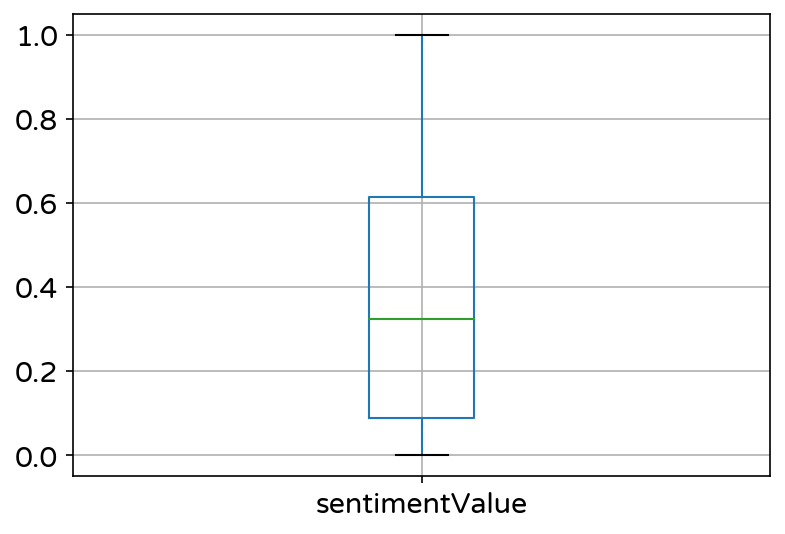

In [234]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [235]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('D')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2023-01-02,0.422463
1,2023-01-04,0.509965
2,2023-01-13,0.361461
3,2023-01-17,0.366189
4,2023-01-20,0.413506
...,...,...
76,2023-12-14,0.393049
77,2023-12-15,0.220429
78,2023-12-17,0.394144
79,2023-12-19,0.389922


/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_87038/857956447.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


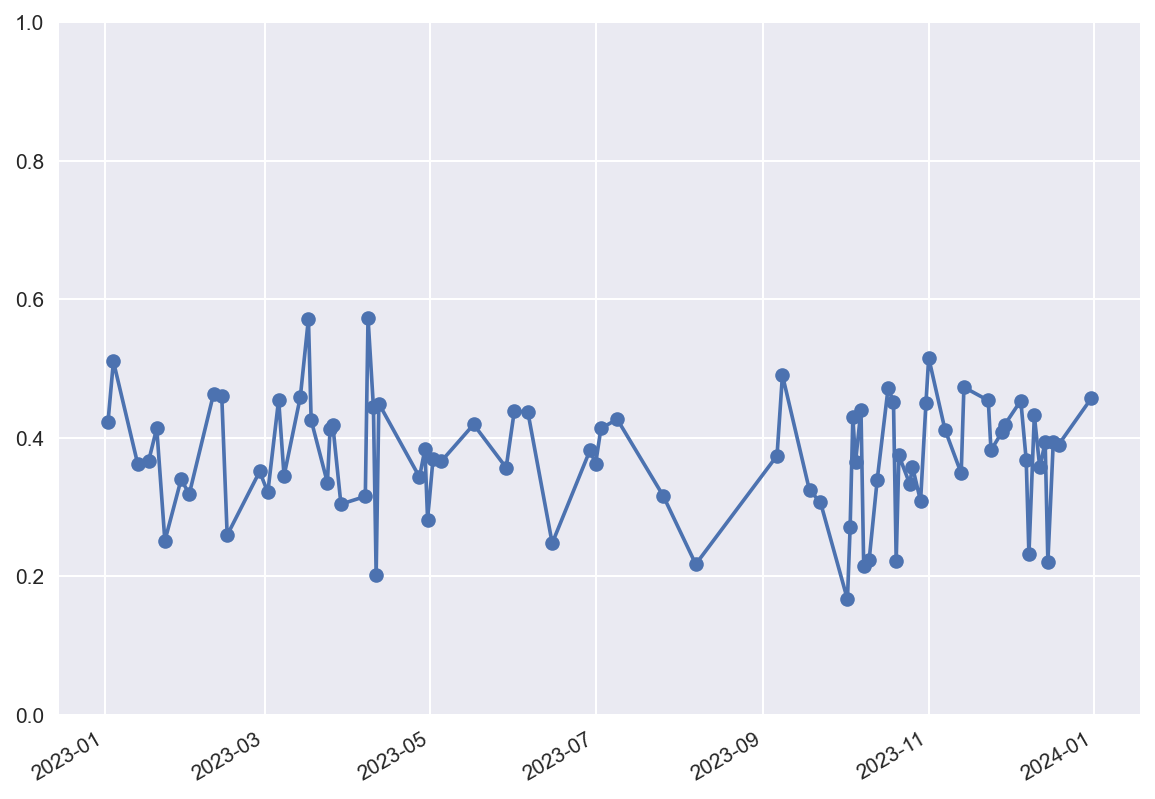

In [236]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

In [243]:
# 篩時間
filter_sentiment = sent_date.loc[sent_date['sentimentValue'] < 0.3]
filter_sentiment.to_csv("filter_sentiment.csv", index = False)
filter_sentiment.head()

,system_id,sentence,artDate,artTitle,llm_class,sentimentValue
2,2,__,2023-01-02,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.250000
3,2,__,2023-01-02,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.250000
4,2,原文內容,2023-01-02,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.256389
6,2,前電競世界冠軍日前開直播，雖然用自動駕駛，但雙手卻完全離開方向盤，甚至不停,2023-01-02,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.013840
7,2,滑手機，遭大量網友留言罵翻，實際上這些行為，警方表示都已經違規，甚至未握方向盤,2023-01-02,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.000068


In [252]:
filter_sentiment['artTitle']
set(filter_sentiment['artTitle'].tolist())

{'Fw:[新聞]中國面臨動力電池產能過剩危機寧德時代',
 'Fw:[新聞]馬斯克：無論和平或武力兩岸「100%會統',
 'Re:[問題]擦撞特斯拉，請幫忙估價',
 'Re:[情報]2023年5月份臺灣汽車市場銷售報告',
 'Re:[新聞]230萬「天坑特斯拉」報廢\u3000建商只丟1句話',
 'Re:[新聞]BMW國道逼車急煞肇逃…5歲童噴飛亡',
 'Re:[新聞]中國首季汽車出口超過日本成全球第一',
 'Re:[新聞]全球銷量最大車商加入NACS陣營！',
 'Re:[新聞]兩大原因多家產險業者對承保特斯拉打退',
 'Re:[新聞]半夜驚覺特斯拉遭「堆高機移到路中」',
 'Re:[新聞]和泰汽車連續21年稱霸台灣車市銷售NO.1',
 'Re:[新聞]沒錢付？開特斯拉2男拔走隔壁槍充電\u3000車',
 'Re:[新聞]馬斯克大罵瘋了瑞典郵政不寄車牌特斯拉',
 'Re:[討論]一人給我一個入坑電車的理由！',
 'Re:[討論]台灣保時捷N7到底生出來了沒？？',
 'Re:[討論]日本的蛇行逼車剪線三寶',
 'Re:[討論]特斯拉全球大降價，只有台灣等三國沒降',
 'Re:[討論]特斯拉車主充電討論',
 'Re:[電車]馬力稅會不會太誇張',
 '[分享]Toyota與Hyundai電動車廣告因誤導消費',
 '[分享]馬斯克籲豐田採用Tesla充電標準轉',
 '[問題]Tesla交車問題',
 '[問題]車禍對方已讀不回怎麼辦',
 '[市調]汽車市場研究活動車馬費1800~2500元',
 '[市調]汽車市場研究活動車馬費800~6000元',
 '[市調]汽車車主問卷/座談會酬金600~2500元',
 '[市調]汽車車主市調訪問車馬費600~4000元',
 '[心得]2024XC40rechargep8與看車心得',
 '[心得]PriusPHEV(MXWH61)1萬公里心得',
 '[情報]特斯拉美國官網全車系調降',
 '[情報]特斯拉車主在超充站發生爭吵後槍擊',
 '[新聞]2023年「10大最可靠汽車」出爐\u3000特斯拉',
 '[新聞]ToyotabZ4X出師不利\u3000豐田想提高電動車',
 '[新聞][U-EV]降幅最高5,900美元，美國Ford調整2',
 '[新聞]iPhone15又有事！

In [249]:
# Define the regular expression pattern for special symbols
sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：_/\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'

# Remove special symbols from the 'sentence' column
filter_sentiment['sentence'] = filter_sentiment['sentence'].apply(lambda x: re.sub(sepical_symbols, '', x))
filter_sentiment = filter_sentiment[filter_sentiment['sentence'] != '']

# Save the filtered DataFrame to a CSV file
filter_sentiment.to_csv("filter_sentiment.csv", index=False)

# Display the first few rows of the filtered DataFrame
filter_sentiment.head()

/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_87038/2690932689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_sentiment['sentence'] = filter_sentiment['sentence'].apply(lambda x: re.sub(sepical_symbols, '', x))


,system_id,sentence,artDate,artTitle,llm_class,sentimentValue
4,2,原文內容,2023-01-02,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.256389
6,2,前電競世界冠軍日前開直播，雖然用自動駕駛，但雙手卻完全離開方向盤，甚至不停,2023-01-02,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.013840
7,2,滑手機，遭大量網友留言罵翻，實際上這些行為，警方表示都已經違規，甚至未握方向盤,2023-01-02,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.000068
10,2,▲駕駛特斯拉開直播,2023-01-02,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.191087
11,2,前電競世界冠軍劉偉健這回邊開車邊開直播，結果聊天室排噓聲,2023-01-02,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,投訴方面,0.001430


In [250]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment, pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

,system_id,sentimentValue,word
0,2,0.256389,原文
1,2,0.256389,連結
2,2,0.256389,////
3,2,0.256389,__
4,2,0.256389,__


In [239]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

In [241]:
# 自定停用字
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['來源', '市場', '排行', '大神', '目前', '是不是', '也將', '紅', '通知', '讀版', '圖片', '以下', '需要', '連結', '記者', '署名', '發文', '發布', '時間', '心得', '評論', '正文', '張數', '原文', '標題', '網址', '內文', '口', '張數', '家數', '年月日', '單位', '統計', '證券', '名稱', '交易所', '代號', '謝謝', '分類', '標的', '報導', '格式', '股票名稱', '業者', '依板', '版規', '刪除', '內容', '未依', '規處份', '輸入', '文處份', '處份', '股號', '板規', '股名', '類免', '第四季', '原文', '萬輛', '$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '進行', '昨天', '不惟', '不成', '10', '拿下', '去年', '希望', '11', '提供', '記者', '報導', '表示', '不用', 'app', '12', '繼續', '成為', '表現', '今天', '今年', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎

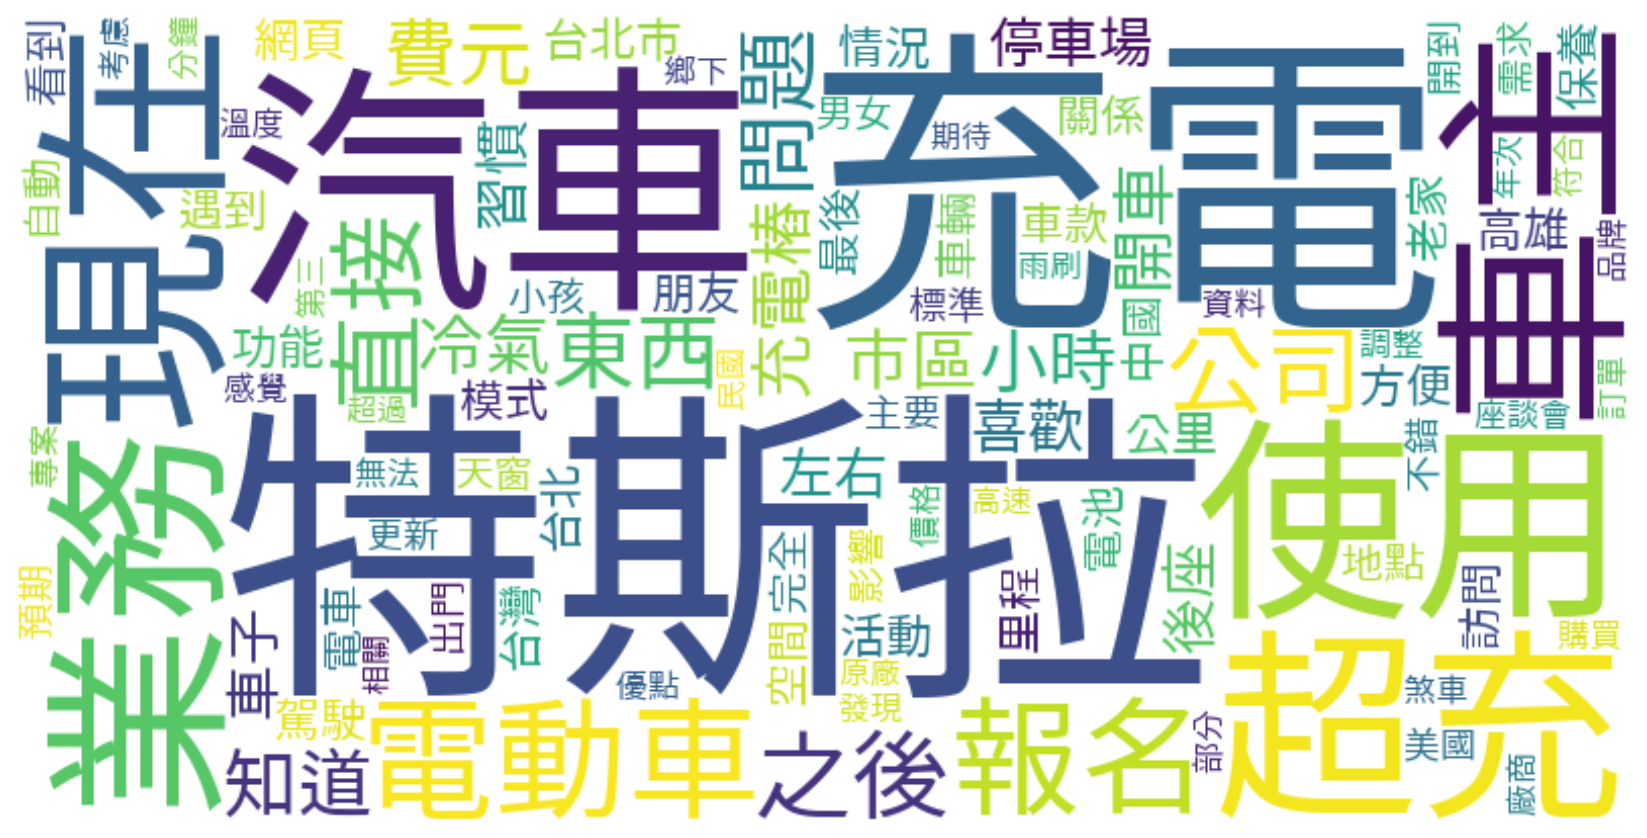

In [242]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
#stop_words_pos.extend((最多','提供'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()